In [1]:
# Módulos
import numpy as np
import control as ct
import controle as ctl
# Simulação Ideal da Planta
NT = 18             # Emanuel(7) + Staub(5) + Araldi(6)
NP = 7              # Emanuel(7)
R1 = NT*2e3         # Resistência de Entrada
R2 = 18e3           # Resistência do Circuito RC
C1 = 100e-9         # Capacitância do Circuito RC
C2 = 680e-9         # Capacitância do Ampop
####
z  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
w2 = 1/(C1*C2*R1*R2)
w  = np.sqrt(w2)
####
print("ζ: ", round(z, 3))# Cálculo de Valores Importantes do Circuito
Mp = np.exp(-np.pi*z/np.sqrt(1-z**2))
Tp = np.pi/(w*np.sqrt(1-z**2))
τ  = 1/(z*w)
Ts = 4*τ
####
Tp_ms = 1e3*Tp
####
print("Mp: ", round(Mp*100, 3), "%")    # Simulado: 24.698%
print("Tp: ", round(Tp*1e3, 3), "ms")   # Simulado: 22.80 ms
print("τ : ", round(τ*1e3 , 3), "ms")   # Simulado: NA
print("Ts: ", round(Ts*1e3, 3), "ms")   # Simulado: 55.82 ms (difícil determinar, mas entre ~56 e ~69)
print("ω: ", round(w, 3))

ζ:  0.407
Mp:  24.69 %
Tp:  22.828 ms
τ :  16.32 ms
Ts:  65.28 ms
ω:  150.646


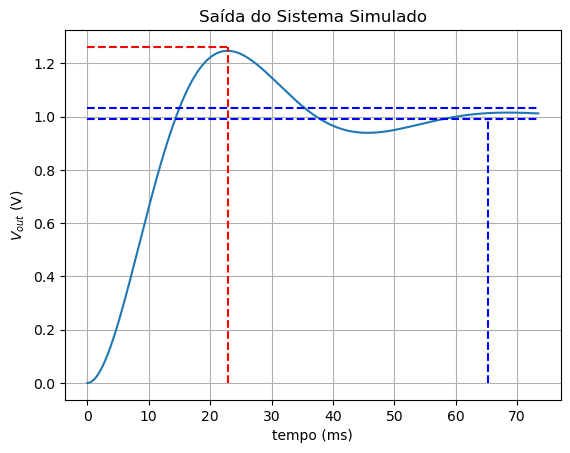

In [2]:
import matplotlib.pyplot as plt
import control as ct

s = ct.tf('s')
t = np.linspace(0, (Ts+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = w2/(s**2 + s*2*z*w + w2)
t, y = ct.step_response(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Simulado")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=Tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=Tp])), 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ys  = y[np.abs(y - y[-1]*(1-2e-2)) <= 1e-5]
plt.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')
plt.savefig("Analogico.svg", format="svg")

## Simulação da Planta com Valores Reais

In [3]:
Mp = 168e-3     # Pico-Final
yf = 500e-3     # Final
Tp = 17.60e-3   # Tempo de pico
Mp = Mp/yf      # Sobresinal em Porcentagem
####
ζ   = -np.log(Mp)/np.sqrt(np.pi**2 + np.log(Mp)**2)
ω   = np.pi/(Tp*np.sqrt(1-ζ**2))
τ   = 1/(ζ*ω)
Ta  = 4*τ     # Tempo de acomodação de 2%
ω2  = ω**2    # Conveniência
####
print("ζ:", ζ)
print("ω:", ω)
print("τ:", τ)
print("#####")
print("Ta:", Ta*1e3, "ms")
print("Mp: ", 100*Mp, "%")

ζ: 0.32796159714045775
ω: 188.95021976249527
τ: 0.01613725292520876
#####
Ta: 64.54901170083505 ms
Mp:  33.6 %


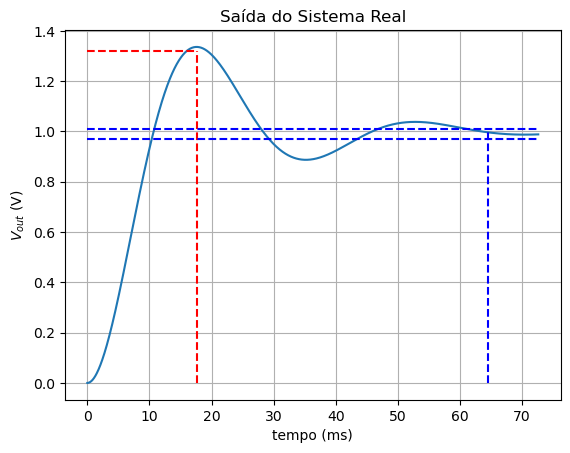

In [4]:
## Reconstruindo Saída da Planta
s = ct.tf('s')
t = np.linspace(0, (Ta+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = ω2/(s**2 + s*2*ζ*ω + ω2)
t, y = ct.step_response(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Real")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=Tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=Tp])), 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ya  = y[np.abs(y - y[-1]*(1+2e-2)) <= 7e-5]
plt.plot([Ta*1e3, Ta*1e3], [0, ya[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')

## Design do Controlador

0 states have been removed from the model


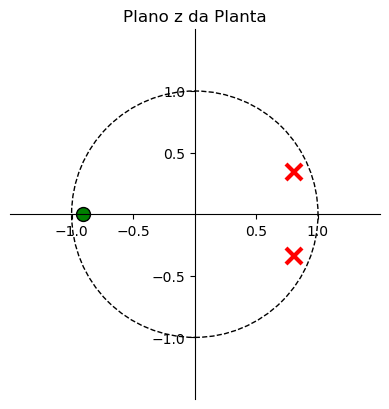

Período de Amostragem: 2.237 ms
Frequência de Amostragem: 446.989 Hz
zeta : 0.5504760521891304
omega: 336.40915794382266
wd   : 280.8515065588941
z1   : (0.5346034457063581+0.38841213892387405j)
Planta: 
 0.08044 z + 0.07331
----------------------
z^2 - 1.604 z + 0.7578

dt = 0.0022371912417931124



In [5]:
## Características Desejadas do Sistema Controlado
fs  = 10e-2             # Fator de Segurança de 10%
Mpc = NP*2e-2*(1-fs)
Tac = NT*1e-3*(1-fs)    # p/ 5%
####
zc  = -np.log(Mpc)/np.sqrt(np.pi**2 + np.log(Mpc)**2)
wc  = 3/(zc*Tac)
wdc = wc*np.sqrt(1-zc**2)
Ts  = 2*np.pi/(wdc*10)    ## Seguindo Regra Geral
####
j  = complex(0, 1)
s1 = -zc*wc+j*wdc
z1 = np.exp(s1*Ts)
####
Gz  = ct.minreal(ct.c2d(G, Ts))
[[[b]], [[a]]] = ct.tfdata(Gz)
ctl.zplane(Gz, title="Plano z da Planta")
plt.show()
print("Período de Amostragem:", round(Ts*1e3, 3), "ms")
print("Frequência de Amostragem:", round(1/Ts, 3), "Hz")
print("==========")
print("zeta :", zc)
print("omega:", wc)
print("wd   :", wdc)
print("==========")
print("z1   :", z1)
print("Planta:", Gz)

0 states have been removed from the model


c:\Users\emanuel\anaconda3\Lib\site-packages\control\xferfcn.py:1113: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


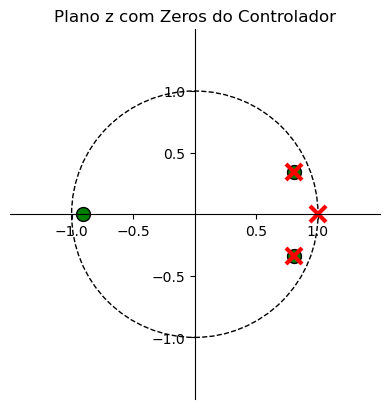

2 states have been removed from the model


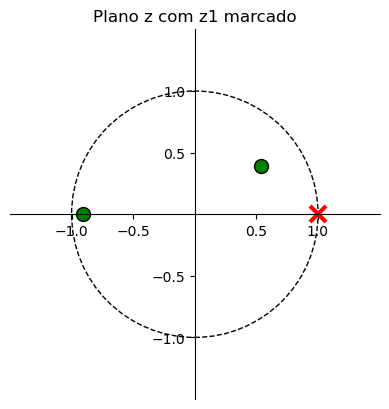

In [6]:
## Cancelando Polos da Planta
z     = ct.tf('z')
alpha = ct.minreal(Gz).poles()
Cz    = 1/(z-1)
for bc in alpha:
  Cz = Cz * (z-bc)
CGz = Cz*Gz
ctl.zplane(CGz, title="Plano z com Zeros do Controlador")
CGz = ct.minreal(CGz)
ctl.zplane((z-z1)*CGz, title="Plano z com z1 marcado")
plt.show()

## Ajustando C(z) por Root Locus

fi1: -140.15219248905473 °
fi2: 39.847807510945266 °
0 states have been removed from the model
0 states have been removed from the model


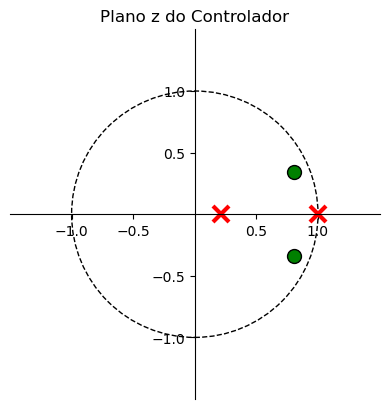

α: [0.80204989+0.33847528j 0.80204989-0.33847528j]
β: -0.21044120541561723
K: 2.5463858254330605

z^2 - 1.604 z + 0.7578
----------------------
z^2 - 1.21 z + 0.2104



In [7]:
fi1 = 0
# for zero in CGz.zeros():
#     fi1 = fi1 + np.arctan2(z1.imag - zero.imag, z1.real - zero.real)
for pole in CGz.poles():
    fi1 = fi1 - np.arctan2(z1.imag - pole.imag, z1.real - pole.real)
##
print("fi1:", (180/np.pi)*fi1, "°")
#fi1 = np.arctan2(-alpha.real[0] - z1.real, z1.imag-alpha.imag[0])
#print("fi1:", (180/np.pi)*fi1, "°")
fi2 =  np.pi+fi1
print("fi2:", (180/np.pi)*fi2, "°")
# fi2 = np.arctan2(-β.real - z1.real, z1.imag+β.imag)
# np.tan(fi2) = (-β - z1.real)/(z1.imag-0)
# z1.imag*np.tan(fi2) = -β - z1.real
# β = -(z1.imag*np.tan(fi2) + z1.real)
β   = -(z1.imag * np.tan(-fi2) + z1.real) # => Adição angular de um polo é invertida
# β   = (z1.imag - z1.real * np.tan(-fi2))/np.tan(fi2)
Cz  = ct.minreal(Cz/(z+β))
CGz = ct.minreal(CGz/(z+β))
ctl.zplane(Cz, title="Plano z do Controlador")
plt.show()
#################################
#        b[0] + ... + b[n]z**-n #
# G(z) = ---------------------- #
#        a[0] + ... + a[n]z**-n #
#################################
#
#|K * C(z)G(z)|z->z1=1
#|K * C(z1)G(z1)| = 1
#
#     |     1    |
# K = |----------|
#     |C(z1)G(z1)|
#
[[[b]], [[a]]] = ct.tfdata(CGz)
b   = np.real(b)
K   = np.abs(np.polyval(a, z1)/np.polyval(b, z1))
# Ajustando ganho do integrador
print("α:", alpha)
print("β:", β)
print("K:", K)
print(Cz)

c:\Users\emanuel\anaconda3\Lib\site-packages\control\statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


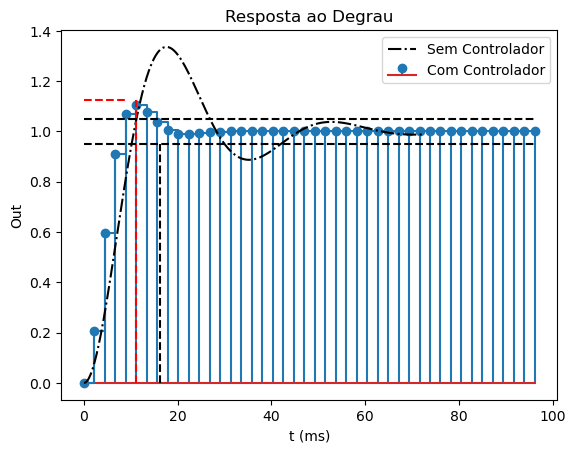

In [8]:
FTMF = ct.feedback(K*CGz, 1)
axcg, tcg, ycg = ctl.plot_step(FTMF, t=np.arange(0, Ta+2*τ, Ts),
                               label = "Com Controlador")
axcg.plot(t*1e3, y, "k-.", label="Sem Controlador")

Tpc  = np.pi/(wc*np.sqrt(1-zc**2))

plt.plot(1e3*(tcg[tcg<=Tpc]), 1*(1+Mpc)*np.ones(len(tcg[tcg<=Tpc])), 'r--')
plt.plot([Tpc*1e3, Tpc*1e3], [0, 1*(1+Mpc)], 'r--')

yscg  = ycg[np.abs(ycg - 1*(1-5e-2)) <= 1e-5]
plt.plot([Tac*1e3, Tac*1e3], [0, 1*(1-5e-2)], 'k--')
plt.plot(tcg*1e3, np.ones(len(ycg))*1*(1-5e-2), 'k--')    # Limite inferior para 5%
plt.plot(tcg*1e3, np.ones(len(ycg))*1*(1+5e-2), 'k--')    # Limite superior para 5%

plt.grid(True, 'both')
plt.legend()
plt.grid()
plt.show()

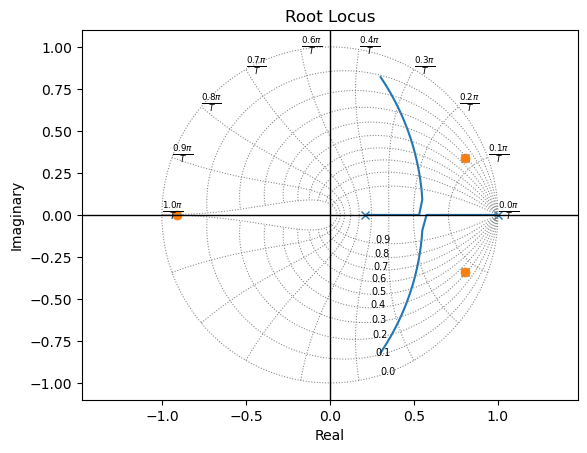

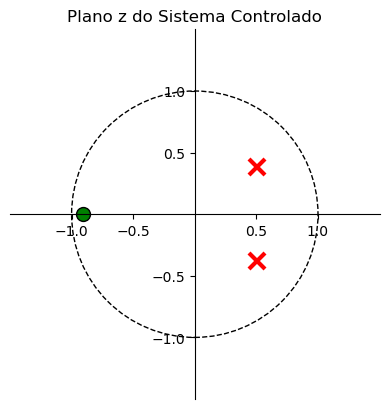

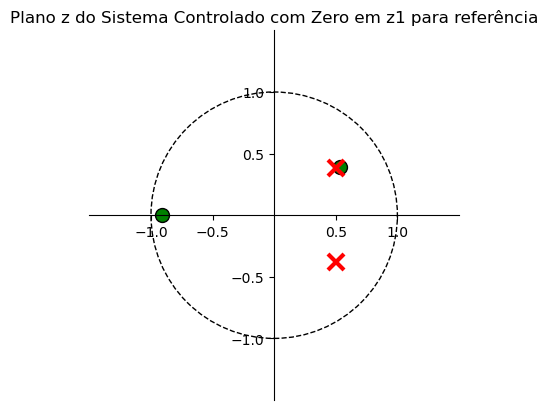

Pólos da FTMF: [0.50279977+0.37986596j 0.50279977-0.37986596j]
z1: (0.5346034457063581+0.38841213892387405j)
Erro: (-4.654+1.783j) %


In [9]:
k = np.linspace(0, K+5, 100)
ct.root_locus(Cz*Gz, k)
plt.show()

ctl.zplane(FTMF, title="Plano z do Sistema Controlado")
ctl.zplane((z-z1)*FTMF, title="Plano z do Sistema Controlado com Zero em z1 para referência")
plt.show()

print("Pólos da FTMF:", FTMF.poles())
print("z1:", z1)
print("Erro:", np.round(100*(FTMF.poles()[0]-z1)/z1, 3), "%")

## Comparação Entre ζ e ω Desejados com os Obtidos

In [10]:
Mpcs = (ycg[ycg == np.max(ycg)]-ycg[-1])/ycg[-1]    # Sobressinal
Tpcs = tcg[ycg == np.max(ycg)]                      # Tempo de Pico, em segundos
ypcs = np.max(ycg)  # Sobressinal Simulado
ypc  = 1*(Mpc+1)    # Sobressinal Desejado
####
print("====================================================")
print("Sobressinal Desejado:", round(100*Mpc, 3), "%")
print("Tempo de Pico Desejado:", round(Tpc*1e3, 3), "ms")
print("----------------------------------------------------")
print("Sobressinal do Sistema Controlado:", 100*Mpcs, "%")
print("Tempo de Pico do Sistema Controlado:", Tpcs*1e3, "ms")
print("----------------------------------------------------")
print("Erro de Sobressinal do Sistema Controlado:", 100*(Mpcs-Mpc), "%")
print("Erro de Tempo de Pico do Sistema Controlado:", 100*(Tpcs-Tpc)/Tpc, "%")
print("====================================================")

Sobressinal Desejado: 12.6 %
Tempo de Pico Desejado: 11.186 ms
----------------------------------------------------
Sobressinal do Sistema Controlado: [10.607686] %
Tempo de Pico do Sistema Controlado: [11.18595621] ms
----------------------------------------------------
Erro de Sobressinal do Sistema Controlado: [-1.992314] %
Erro de Tempo de Pico do Sistema Controlado: [1.55080482e-14] %


Podemos ver pelo gráfico que o tempo de acomodação está próximo de 17 ms, o que está bem próximo dos $18\cdot(1-10\%) \approx 16.2\space ms$

## Resposta ao Impulso do Microcontrolador

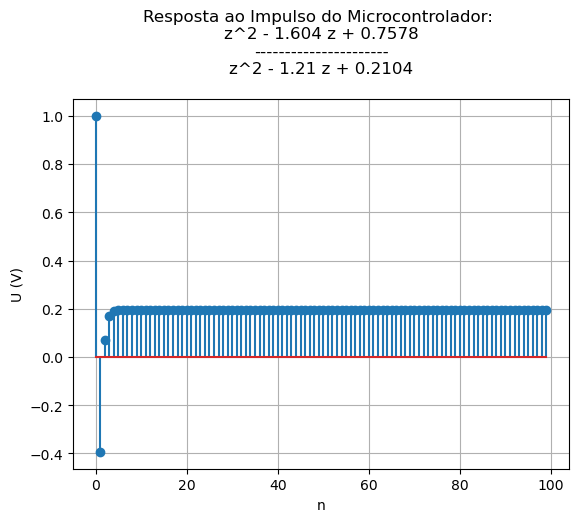

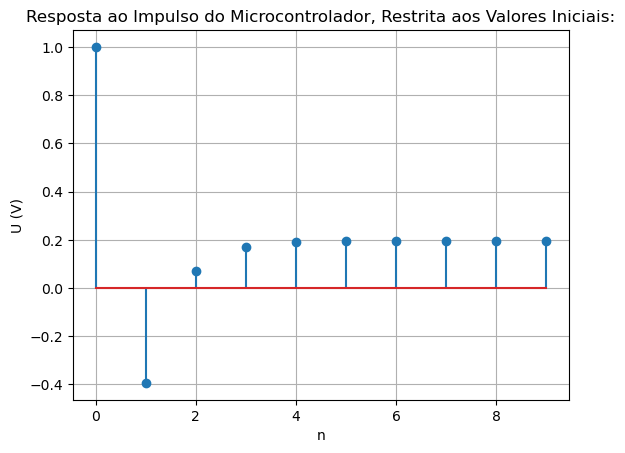

In [11]:
import scipy.signal as sp

Erro    = np.zeros(100)
Erro[0] = 1
[[[b]], [[a]]] = ct.tfdata(Cz)
b              = np.real(b)
Clfilt = sp.lfilter(b, a, Erro)
####
plt.stem(Clfilt)
plt.title("Resposta ao Impulso do Microcontrolador: " + str(Cz))
plt.xlabel("n")
plt.ylabel("U (V)")
plt.grid(True)
plt.show()
####
plt.stem(Clfilt[0:10])
plt.title("Resposta ao Impulso do Microcontrolador, Restrita aos Valores Iniciais:")
plt.xlabel("n")
plt.ylabel("U (V)")
plt.grid(True)
plt.show()

## Resposta ao Degrau do Microcontrolador

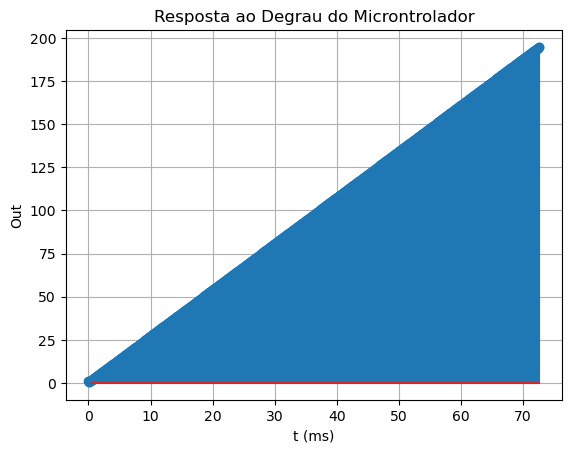

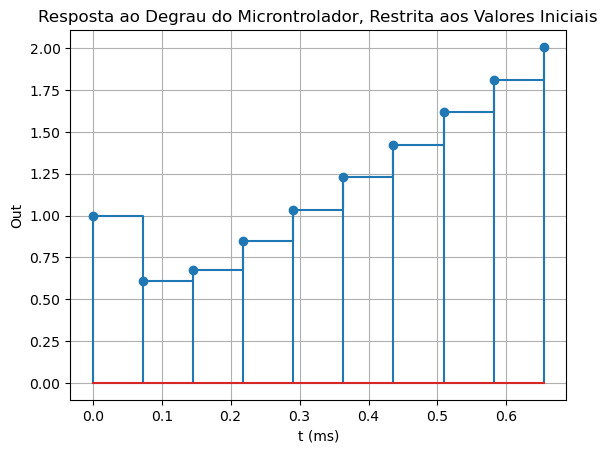

In [12]:
ctl.plot_step(Cz, t, "Resposta ao Degrau do Microntrolador")
plt.show()
ctl.plot_step(Cz, t[:10], "Resposta ao Degrau do Microntrolador, Restrita aos Valores Iniciais")
plt.show()

## Implementação Da Equação Recursiva da Planta

b = [0.08044408 0.07330569]
a = [ 1.         -1.60409979  0.75784955]


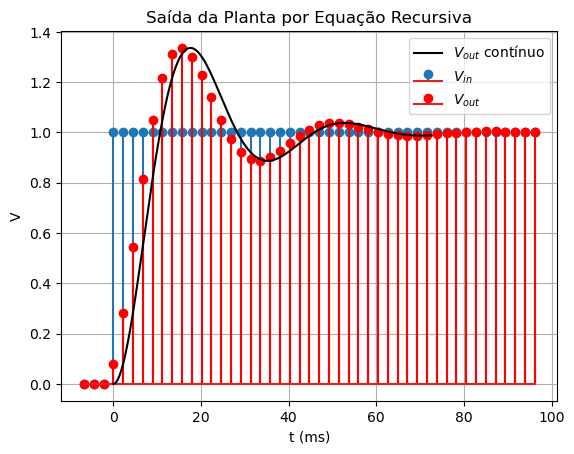

In [13]:
[[[b]], [[a]]] = ct.tfdata(Gz)

print("b =", b)
print("a =", a)
# Verificando Coeficientes
tz = np.arange(-len(a)*Ts, (Ta+2*τ), Ts)
u  = np.heaviside(tz, 0) # degrau
ua = 0 # Acumula b[0]*x[k] + ... + b[n]*x[k-n]
ya = 0 # Acumula a[1]*y[k-1] + ... + a[n]*y[k-n]
yf = np.zeros(len(tz))
n0 = len(a)
for n in range(n0, len(tz)): # i = n-max(len(a), len(b))
    j = 0
    ua=0
    ya=0
    for bn in b:
        ua = ua + bn*u[n-j]
        j  = j+1
    j = 1
    for an in a[1:]:
        ya = ya + an*yf[n-j]
        j = j+1
    yf[n] = (ua-ya)/a[0]
    n = n+1

plt.stem(1e3*tz, u, label="$V_{in}$")
plt.stem(1e3*tz, yf, "r", label="$V_{out}$")
plt.plot(1e3*t, y, "k", label="$V_{out}$ contínuo")
plt.legend()
plt.title("Saída da Planta por Equação Recursiva")
plt.xlabel("t (ms)")
plt.ylabel("V")
plt.grid(True)
plt.show()

## Saída do Microcontrolador por Equação Recursiva

b = [ 1.         -1.60409979  0.75784955]
a = [ 1.         -1.21044121  0.21044121]


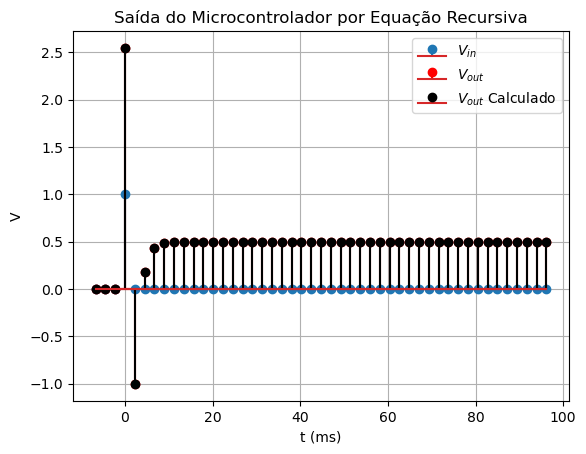

In [14]:
[[[b]], [[a]]] = ct.tfdata(Cz)

b = np.real(b)
print("b =", b)
print("a =", a)
b = K*b
# Verificando Coeficientes
tz    = np.arange(-len(a)*Ts, (Ta+2*τ), Ts)
erro  = np.zeros(len(tz))
erro[len(a)] = 1
erroa = 0 # Acumula b[0]*x[k] + ... + b[n]*x[k-n]
ua    = 0 # Acumula a[1]*y[k-1] + ... + a[n]*y[k-n]
uf    = np.zeros(len(tz))
n0    = len(a)
for n in range(n0, len(tz)): # i = n-max(len(a), len(b))
    j     = 0
    ua    = 0
    erroa = 0
    for bn in b:
        erroa = erroa + bn*erro[n-j]
        j  = j+1
    j = 1
    for an in a[1:]:
        ua = ua + an*uf[n-j]
        j = j+1
    uf[n] = (erroa-ua)/a[0]
    n = n+1

h_Cz         = np.zeros(len(tz))
h_Cz[len(a)] = 1
h_Cz         = sp.lfilter(b, a, h_Cz)

plt.stem(1e3*tz, erro, label="$V_{in}$")
plt.stem(1e3*tz, uf, "r", label="$V_{out}$")
plt.stem(1e3*tz, h_Cz, "k", label="$V_{out}$ Calculado")
plt.legend()
plt.title("Saída do Microcontrolador por Equação Recursiva")
plt.xlabel("t (ms)")
plt.ylabel("V")
plt.grid(True)
plt.show()

## Simulação por Equações Recursvias - Planta + Microcontrolador

b = [ 2.54638583 -4.08465697  1.92977735]
a = [ 1.         -1.21044121  0.21044121]


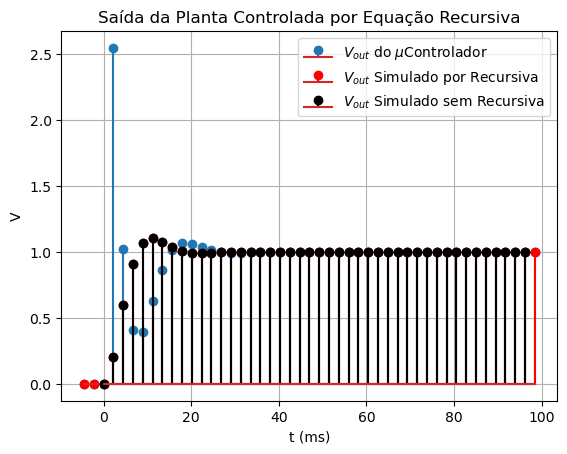

In [21]:
[[[cb]], [[ca]]] = ct.tfdata(K*Cz)
[[[gb]], [[ga]]] = ct.tfdata(Gz)

cb = np.real(cb)
gb = np.real(gb)

print("b =", cb)
print("a =", ca)

n0   = max(len(ga), len(ca))
tz   = np.arange(-n0*Ts, (Ta+2*τ), Ts)
Ref  = 1
Erro = np.heaviside(tz, 1)
U    = np.zeros(len(tz))
Y    = np.zeros(len(tz))
#####
erroa = 0 # Acumula b[0]*Erro[k] + ... + b[n]*Erro[k-n]
ua    = 0 # Acumula a[1]*U[k-1] + ... + a[n]*U[k-n]
ya    = 0 # Acumula a[1]*Y[k-1] + ... + a[n]*Y[k-n]
###
y_prv = 0
for n in range(n0, len(tz)): # i = n-max(len(a), len(b))
    Erro[n] = Ref - y_prv
    # Microcontrolador
    j     = 0
    ua    = 0
    erroa = 0
    for bn in cb:
        erroa = erroa + bn*Erro[n-j]
        j     = j+1
    j = 1
    for an in ca[1:]:
        ua = ua + an*U[n-j]
        j  = j+1
    U[n] = (erroa-ua)/ca[0]
    ## Planta
    j  = 0
    ua = 0
    ya = 0
    for bn in gb:
        ua = ua + bn*U[n-j]
        j  = j+1
    j = 1
    for an in ga[1:]:
        ya = ya + an*Y[n-j]
        j  = j+1
    Y[n]    = (ua-ya)/ga[0]
    y_prv   = Y[n]
    n       = n+1

plt.stem(1e3*(tz+Ts), U, label="$V_{out}$ do $\mu$Controlador")
plt.stem(1e3*(tz+Ts), Y, "r", label="$V_{out}$ Simulado por Recursiva")
plt.stem(1e3*tcg, ycg, "k", label="$V_{out}$ Simulado sem Recursiva")
plt.legend()
plt.title("Saída da Planta Controlada por Equação Recursiva")
plt.xlabel("t (ms)")
plt.ylabel("V")
plt.grid(True)
plt.show()

## Comparação Com a Simulação em C

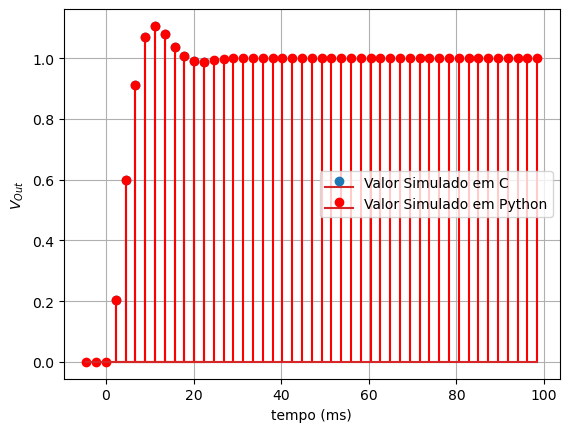

In [16]:
import pandas as pd

df = pd.read_csv('Controle P1/Simulacao em C.csv')
#print(df)
####
tcms = 1e3*df['t']
Yc   = df['Y']

plt.stem(tcms, Yc)
plt.stem(1e3*(tz+1*Ts), Y, "r", label="$V_{out}$ Simulado por Recursiva")

plt.legend(["Valor Simulado em C", "Valor Simulado em Python"])

plt.ylabel("$V_{Out}$")
plt.xlabel("tempo (ms)")
plt.grid(True)
plt.show()